## Purpose: Check whether or not the maximum likelihood method works properly.
#### Note that this project is based on the EventDisplay dataset.

In [1]:
%load_ext autoreload
%autoreload 2

from DarkMatter import *

Welcome to JupyROOT 6.26/08


## 1. Generate a pseudo signal.
#### Assuming that $<\sigma\nu> = 10^{-22.5}$.

In [21]:
M = 1000
dwarf="Segue_1"
sigma = -22.5
jSeed = defaultNum[dwarf]
hg_1d = Likelihood.combinedCalcSignal(dwarf, M, "EventDisplay", ext=True, channel="tt", jSeed=jSeed, sigma=sigma, addTheta=False, averagedIRF=True)

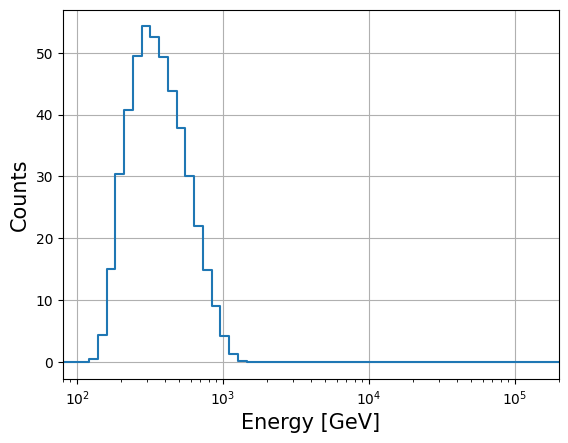

In [22]:
x_s, y_s = getArray(hg_1d)
plt.step(x_s, y_s, where="mid")
plt.xscale("log")
plt.xlim(80, 2e5)
plt.xlabel("Energy [GeV]", fontsize=15)
plt.ylabel("Counts", fontsize=15)
plt.grid()

## 2. Generate a pseudo "on-region" count spectrum.
#### The pseudo signal + observed background

In [23]:
hOn, hOff, n1, n2, evts, alpha = Likelihood.eventdisplay.readData(dwarf, ext=True, full_output=True, bkgModel="ex")

Total events: 2323


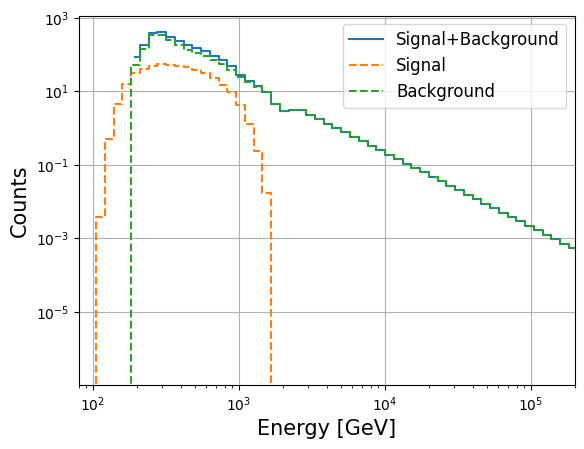

In [24]:
x_off, y_off = getArray(hOff)
x_s, y_s = getArray(hg_1d)

x_on = x_off[y_off>0]
y_on = (y_off + y_s)[y_off>0]
N_on = int(sum(y_on))

plt.step(x_on, y_on, label="Signal+Background", where="mid")
plt.step(x_s, y_s, ls="--", label="Signal", where="mid")
plt.step(x_off, y_off, ls="--", label="Background", where="mid")

plt.xscale("log")
plt.yscale("log")
plt.xlim(80, 2e5)
plt.xlabel("Energy [GeV]", fontsize=15)
plt.ylabel("Counts", fontsize=15)
plt.legend(fontsize=12)
plt.grid()

print("Total events: {}".format(N_on))

## 3. Generate events based on the pseudo count spectrum

[ 608146.64231321 1542881.73429402  246977.25642946 ...  282510.98561487
  328019.91003221  531655.03953203]
[ 608146.64231321 1542881.73429402  246977.25642946 ...  282510.98561487
  328019.91003221  531655.03953203]


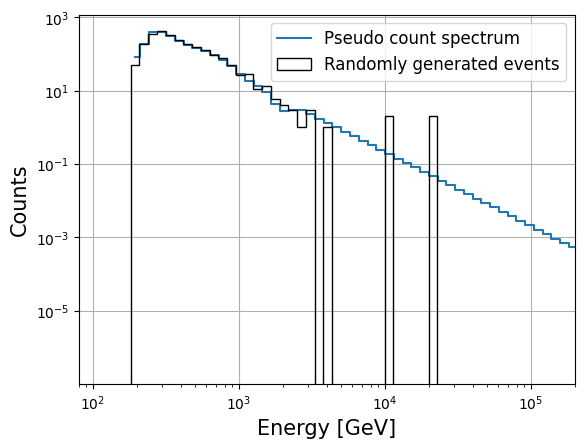

In [25]:
from DarkMatter.Likelihood.simulation import generateFakeEvents

events = generateFakeEvents(dwarf, M, sigma, addTheta=False, ext=True)
bEdges = [hOff.GetXaxis().GetBinLowEdge(i) for i in range(1, hOff.GetNbinsX()+1)]

plt.step(x_on, y_on, label="Pseudo count spectrum", where="mid")
plt.hist(events[:,0], bins=bEdges, color="k", label="Randomly generated events", histtype="step")
plt.xscale("log")
plt.yscale("log")
plt.xlim(80, 2e5)
plt.xlabel("Energy [GeV]", fontsize=15)
plt.ylabel("Counts", fontsize=15)
plt.legend(fontsize=12)
plt.grid()

## 4. Perform the maximum likelihood estimation with the pseudo data.
#### To do this, you need to update args.

In [26]:
mle = Likelihood.MLE(dwarf, M, package="EventDisplay", jArray=True, jSeed=defaultNum[dwarf],ext=True,
                     addTheta=False, channel="tt", averagedIRF=True,  useBias=True, 
                     verbose=True) 

mle.N_on = int(N_on)
mle.events = events
mle.updateArgs(forced=True)

mle.minuit(method=2)

[Log] Initializing... (EventDisplay)
[Log] Step 1: Instrument response functions are imported.
[Log] Step 2: Events are loaded.
[Log] Step 3: A source model is loaded.
[Log] Step 4: Assigning probabilities for each event...

[Warning] 1 events have p_bkg of 0. They are ignored when calculating the likelihood.
      Energy      
------------------
62290.446171057825


[Log] Step 4: A temporary file for minimization is generated.
[Log] Initialization is done. Run minuite.
[Warning] The number of events and the pre-defined N_on are different.
[Log, Result] TS = 70.09 (M=1000 GeV)
[Log, Result] <σν> = 10^(-22.576 +/- 0.078)
[Log, Result] b = 11338 +/- 150 (null value: 11670)


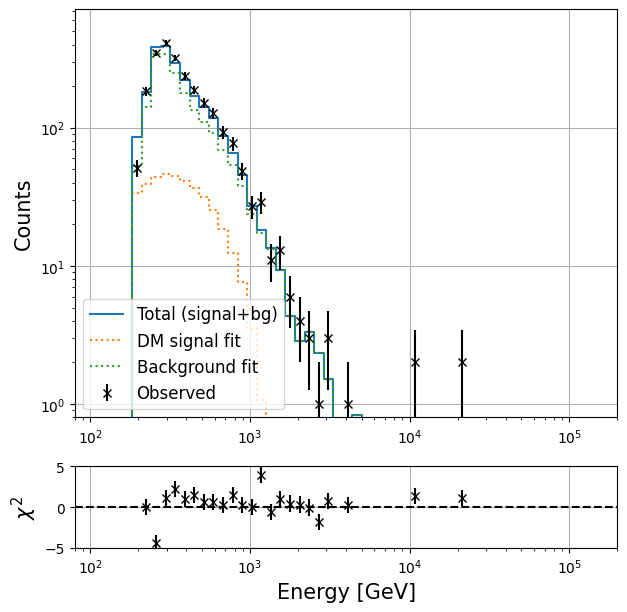

In [27]:
mle.plotSED()

#### Check the consistency between the input and output.

Total events: 2323


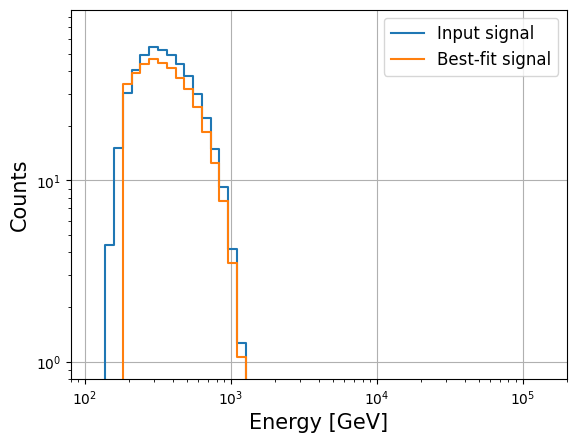

In [28]:
hSignal_fit = mle.hSignal.Clone()
hSignal_fit.Scale(10**(mle.signu[0]-mle.signu0))

x_fit, y_fit = getArray(hSignal_fit)
x_s, y_s = getArray(hg_1d)

plt.step(x_s, y_s, label="Input signal", where="mid")
plt.step(x_fit, y_fit, label="Best-fit signal", where="mid")


plt.xscale("log")
plt.yscale("log")
plt.xlim(80, 2e5)
plt.ylim(0.8,)
plt.xlabel("Energy [GeV]", fontsize=15)
plt.ylabel("Counts", fontsize=15)
plt.legend(fontsize=12)
plt.grid()

print("Total events: {}".format(N_on))

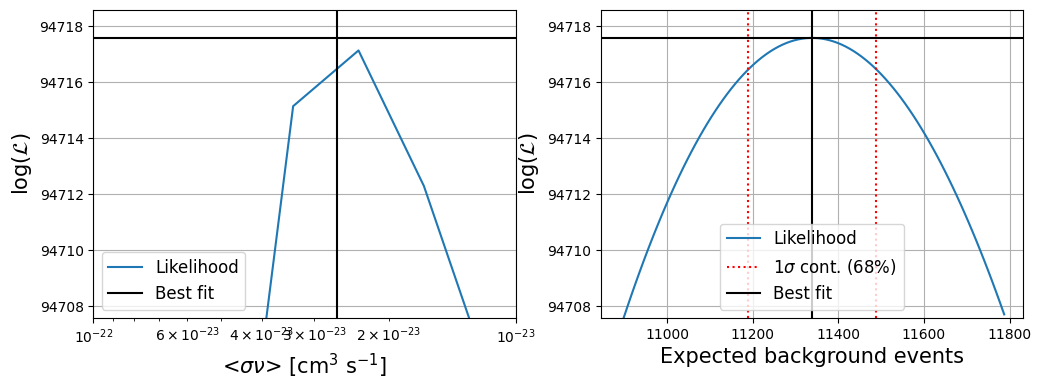

In [29]:
mle.plotProfileLikelihood(invert=False, upperLimit=False, xlim=[1e-22, 1e-23], error=True)

In [30]:
mle.plotContour()

SegmentationViolation: TObject* TMinuit::Contour(int npoints = 10, int pa1 = 0, int pa2 = 1) =>
    SegmentationViolation: segfault in C++; program state was reset

[/opt/local/libexec/root6/lib/root/libCore.6.26.08.so] TUnixSystem::DispatchSignals(ESignals) (no debug info)
[/usr/lib/system/libsystem_platform.dylib] _sigtramp (no debug info)
[/opt/local/libexec/root6/lib/root/libcppyy_backend3_10.6.26.08.so] WrapperCall(long, unsigned long, void*, void*, void*) (no debug info)
[/opt/local/libexec/root6/lib/root/libcppyy_backend3_10.6.26.08.so] WrapperCall(long, unsigned long, void*, void*, void*) (no debug info)
[/opt/local/libexec/root6/lib/root/libcppyy_backend3_10.6.26.08.so] Cppyy::CallR(long, void*, unsigned long, void*) (no debug info)
[/opt/local/libexec/root6/lib/root/libcppyy3_10.6.26.08.so] CPyCppyy::(anonymous namespace)::InstancePtrExecutor::Execute(long, void*, CPyCppyy::CallContext*) (no debug info)
[/opt/local/libexec/root6/lib/root/libcppyy3_10.6.26.08.so] CPyCppyy::CPPMethod::ExecuteFast(void*, long, CPyCppyy::CallContext*) (no debug info)
[/opt/local/libexec/root6/lib/root/libcppyy3_10.6.26.08.so] CPyCppyy::CPPMethod::ExecuteProt

 *** Break *** segmentation violation


In [31]:
mle.ts

70.09434006511583

## Conclusion
<font size=3>The maximum likelihood estimation works properly. The assumed $<\sigma\nu>$ was $10^{-22.5}$, and the MLE found the best-fit value of $10^{-22.52+/-0.04 (1 \sigma)}$ with TS of 164. </font>